# Importing Data

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
data = r'D:\other studies\Quantium Case Comp 2024\QuantiumCaseComp2024\Risky Lending Data Set - revised.xlsx'

customers = pd.read_excel(data, sheet_name="Customers",header=5, usecols=range(1,8))
applications = pd.read_excel(data, sheet_name="Applications",header=5, usecols=range(1,10))
campaigns = pd.read_excel(data, sheet_name="Campaigns",header=5, usecols=range(1,8))
clawbacks= pd.read_excel(data, sheet_name="Clawbacks",header=5, usecols=range(1,5))

# DATES ARE YEAR-MONTH-DAY

# Descriptive analysis
## Revenue measurement
Measure revenue by getting summing loan amounts from applications sheet that do not have a clawback within 12 months (keep track of the account ID).
- Track clawbacks, check which ones closed the account within 1 year (difference between open date and close date should be less than 1 year or 365/366 days depending on leap or non-leap year).
- Remove the corresponding rows from the applications column by matching Account IDs.
- Sum the remaining loan values and multiply by 4% to get revenue for risky lending. Can do this by year also for comparison of revenue over the 3 years.
- Calculate potential revenue lost due to the clawbacks (track the Account IDs we removed) and multiply 4% by the corresponding loan amounts to get the amount that was lost.

### Measuring total revenue from applications
First calculating 4% of loan value for each application then summing to find total revenue

<Axes: ylabel='Loan Amount'>

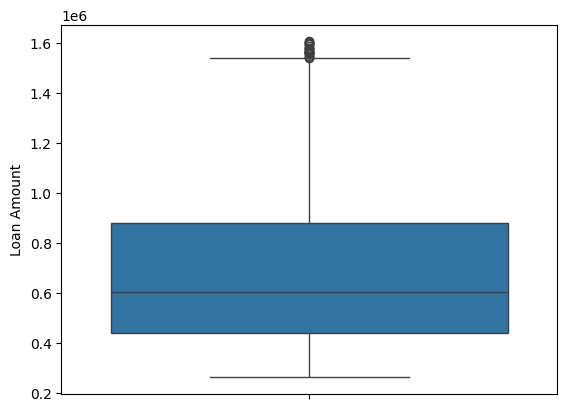

In [7]:
#checking for outliers and possible errors
sns.boxplot(data = applications['Loan Amount'])

<Axes: xlabel='Loan Amount', ylabel='Count'>

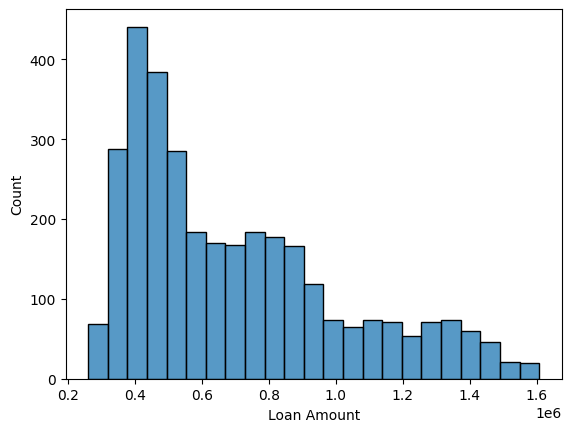

In [8]:
sns.histplot(data = applications['Loan Amount'])

In [9]:
total_revenue_from_applications = round(applications['Loan Amount'].sum()*0.04,2)
print('Total revenue from applications: $', total_revenue_from_applications)

Total revenue from applications: $ 91076973.44


In [10]:
#calculating revenue by year
yearly_revenue = {}
for year in [2020,2021,2022]:
    yearly_applications = applications[(applications['Application Date']<=pd.to_datetime(f'{year}/12/31'))*(applications['Application Date']>pd.to_datetime(f'{year-1}/12/31'))]
    yearly_revenue[year] = round(sum(yearly_applications['Loan Amount']*0.04),2)
    print('Application commission in year',year,' was $',yearly_revenue[year])
print('in total: $', sum(list(yearly_revenue.values())))

Application commission in year 2020  was $ 15026363.18
Application commission in year 2021  was $ 50552646.12
Application commission in year 2022  was $ 25497964.14
in total: $ 91076973.44


### Measuring loss from clawbacks
getting applications clawbacked, i.e closed within 1 year

In [11]:
clawbacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Account ID          376 non-null    int64         
 1   Account Open Date   376 non-null    datetime64[ns]
 2   Account Close Date  376 non-null    datetime64[ns]
 3   Close Reason        376 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 11.9+ KB


In [12]:
clawbacks

,Account ID,Account Open Date,Account Close Date,Close Reason
0,10040,2020-07-09,2021-01-29,REFINANCE
1,10230,2020-09-20,2020-12-10,REFINANCE
2,10393,2020-12-10,2021-04-16,DEFAULT
3,10331,2020-11-16,2021-05-20,REFINANCE
4,10326,2020-11-07,2021-03-15,DEFAULT
...,...,...,...,...
371,11923,2022-01-08,2022-04-30,REFINANCE
372,11961,2022-01-18,2022-04-20,REFINANCE
373,12343,2022-04-08,2022-05-20,REFINANCE
374,12334,2022-04-12,2022-06-04,DEFAULT


In [13]:
clawbacks['open date + 12 mths'] = clawbacks['Account Open Date']+ pd.DateOffset(months=12)
clawbacks

,Account ID,Account Open Date,Account Close Date,Close Reason,open date + 12 mths
0,10040,2020-07-09,2021-01-29,REFINANCE,2021-07-09
1,10230,2020-09-20,2020-12-10,REFINANCE,2021-09-20
2,10393,2020-12-10,2021-04-16,DEFAULT,2021-12-10
3,10331,2020-11-16,2021-05-20,REFINANCE,2021-11-16
4,10326,2020-11-07,2021-03-15,DEFAULT,2021-11-07
...,...,...,...,...,...
371,11923,2022-01-08,2022-04-30,REFINANCE,2023-01-08
372,11961,2022-01-18,2022-04-20,REFINANCE,2023-01-18
373,12343,2022-04-08,2022-05-20,REFINANCE,2023-04-08
374,12334,2022-04-12,2022-06-04,DEFAULT,2023-04-12


In [14]:
sum(clawbacks['Account Close Date']<clawbacks['open date + 12 mths'])

376

All are closed within 12 mths

In [15]:
clawbacked_bool_array = applications["Account ID"].isin(clawbacks["Account ID"])
clawbacked_applications = applications[clawbacked_bool_array]
len(clawbacked_applications)

376

In [16]:
total_loss_from_clawbacks = round(clawbacked_applications['Loan Amount'].apply(func= lambda x: x * 0.04).sum(),2)
print('Total loss from clawbacked: $', total_loss_from_clawbacks)

Total loss from clawbacked: $ 10827669.69


In [17]:
#finding yearly clawbacked loss
yearly_clawbacked_losses = {}
for year in [2020,2021,2022]:
    yearly_clawbacks = clawbacks[(clawbacks['Account Close Date']<= pd.to_datetime(f'{year}/12/31'))*(clawbacks['Account Close Date']> pd.to_datetime(f'{year-1}/12/31'))]
    yearly_clawbacked_bool_array= applications["Account ID"].isin(yearly_clawbacks["Account ID"])
    yearly_clawbacked_applications = applications[yearly_clawbacked_bool_array]
    yearly_loss_from_clawbacks = round(yearly_clawbacked_applications['Loan Amount'].apply(func= lambda x: x * 0.04).sum(),2)
    yearly_clawbacked_losses[year] = yearly_loss_from_clawbacks
    print('Yearly loss from clawbacked: $', yearly_loss_from_clawbacks)
print('in total: $', sum(list(yearly_clawbacked_losses.values())))

Yearly loss from clawbacked: $ 696265.26
Yearly loss from clawbacked: $ 6074415.93
Yearly loss from clawbacked: $ 4056988.5
in total: $ 10827669.69


### Revenue - clawback loss:

In [18]:
print('Revenue - clawback loss: $',total_revenue_from_applications-total_loss_from_clawbacks)

Revenue - clawback loss: $ 80249303.75


In [19]:
#yearly revenue - clawback loss
for year in [2020,2021,2022]:
    print(f'revenue - loss for year {year}: $', yearly_revenue[year]-yearly_clawbacked_losses[year])


revenue - loss for year 2020: $ 14330097.92
revenue - loss for year 2021: $ 44478230.19
revenue - loss for year 2022: $ 21440975.64


# Investigating application opening amounts
- by month
- clawbacks by month (when they actually occur)

In [20]:
#splitting applications by year, then grouping by month and finding no. of applications per month
applications['Account Open Date'] = applications['Application Date'] + pd.DateOffset(weeks=3)
monthly_applications_size = {}
for year in [2020,2021,2022]:
    yearly_applications = applications.loc[(pd.to_datetime(f"{year-1}/12/31")<applications['Account Open Date'])*(applications['Account Open Date']<= pd.to_datetime(f"{year}/12/31"))]
    yearly_applications = yearly_applications.groupby(yearly_applications['Account Open Date'].dt.month)
    yearly_applications = yearly_applications.size()
    yearly_applications = pd.DataFrame(yearly_applications)
    yearly_applications['year'] = year
    monthly_applications_size[year] = yearly_applications

In [43]:
#concatenating all years tgt and preparing to plot
no_of_applications_by_month = pd.concat([monthly_applications_size[year] for year in [2020,2021,2022]])
no_of_applications_by_month['Month'] = np.arange(len(no_of_applications_by_month))
no_of_applications_by_month.rename(columns={0:'No. of Accounts opened'},inplace=True)
no_of_applications_by_month

no_of_applications_by_month

,No. of Accounts opened,year,Month
Account Open Date,,,
7,47,2020,0
8,96,2020,1
9,98,2020,2
10,81,2020,3
11,88,2020,4
12,97,2020,5
1,87,2021,6
2,82,2021,7
3,96,2021,8


<Axes: xlabel='Month', ylabel='No. of Accounts opened'>

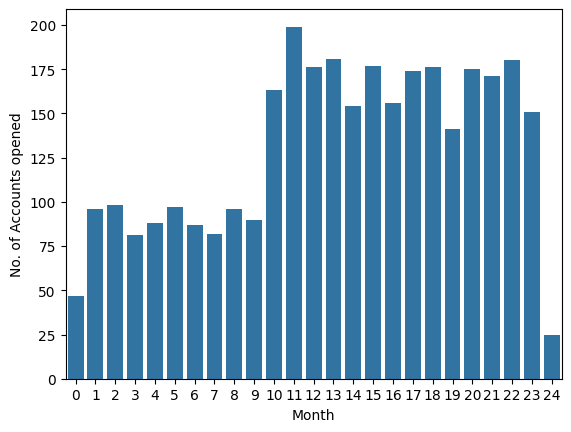

In [44]:
#plotting chart of account opening counts by month
sns.barplot(data=no_of_applications_by_month, x="Month", y = "No. of Accounts opened")

- Repeating for clawbacks (closure dates)

In [38]:
clawbacks

,Account ID,Account Open Date,Account Close Date,Close Reason,open date + 12 mths
0,10040,2020-07-09,2021-01-29,REFINANCE,2021-07-09
1,10230,2020-09-20,2020-12-10,REFINANCE,2021-09-20
2,10393,2020-12-10,2021-04-16,DEFAULT,2021-12-10
3,10331,2020-11-16,2021-05-20,REFINANCE,2021-11-16
4,10326,2020-11-07,2021-03-15,DEFAULT,2021-11-07
...,...,...,...,...,...
371,11923,2022-01-08,2022-04-30,REFINANCE,2023-01-08
372,11961,2022-01-18,2022-04-20,REFINANCE,2023-01-18
373,12343,2022-04-08,2022-05-20,REFINANCE,2023-04-08
374,12334,2022-04-12,2022-06-04,DEFAULT,2023-04-12


In [45]:
#splitting applications by year, then grouping by month and finding no. of applications per month
account_closure_monthly_size = {}
for year in [2020,2021,2022]:
    yearly_clawbacks = clawbacks.loc[(pd.to_datetime(f"{year-1}/12/31")<clawbacks['Account Close Date'])*(clawbacks['Account Close Date']<= pd.to_datetime(f"{year}/12/31"))]
    yearly_clawbacks = yearly_clawbacks.groupby(yearly_clawbacks['Account Close Date'].dt.month)
    yearly_clawbacks = yearly_clawbacks.size()
    yearly_clawbacks = pd.DataFrame(yearly_clawbacks)
    yearly_clawbacks['year'] = year
    account_closure_monthly_size[year] = yearly_clawbacks

#concatenating all years tgt and preparing to plot
no_of_clawbacks_by_month = pd.concat([account_closure_monthly_size[year] for year in [2020,2021,2022]])
no_of_clawbacks_by_month['Month'] = np.arange(len(no_of_clawbacks_by_month))
no_of_clawbacks_by_month.rename(columns={0:'No. of Accounts Closed'},inplace=True)
no_of_clawbacks_by_month

,No. of Accounts Closed,year,Month
Account Close Date,,,
7,1,2020,0
8,3,2020,1
9,3,2020,2
10,8,2020,3
11,4,2020,4
12,6,2020,5
1,7,2021,6
2,10,2021,7
3,6,2021,8


<Axes: xlabel='Month', ylabel='No. of Accounts Closed'>

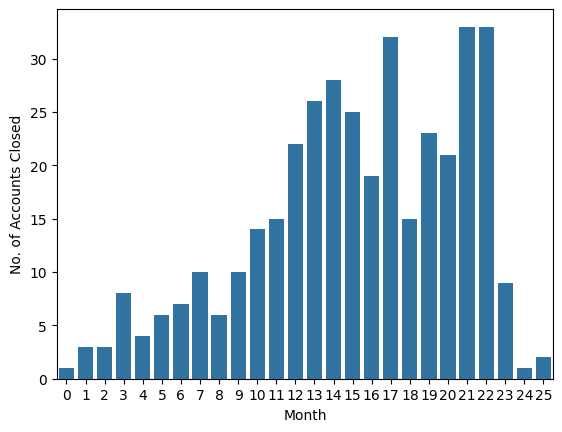

In [50]:
sns.barplot(data=no_of_clawbacks_by_month,x = 'Month', y="No. of Accounts Closed")

In [ ]:
#plotting them together

In [91]:
accounts_opening_and_closing_by_month = pd.concat([no_of_applications_by_month['No. of Accounts opened'].reset_index().drop(columns={'Account Open Date'}), no_of_clawbacks_by_month['No. of Accounts Closed'].reset_index().drop(columns={'Account Close Date'})], axis= 1)
accounts_opening_and_closing_by_month.index.names = ['Month']
accounts_opening_and_closing_by_month = accounts_opening_and_closing_by_month.reset_index()
accounts_opening_and_closing_by_month

,Month,No. of Accounts opened,No. of Accounts Closed
0,0,47.0,1
1,1,96.0,3
2,2,98.0,3
3,3,81.0,8
4,4,88.0,4
5,5,97.0,6
6,6,87.0,7
7,7,82.0,10
8,8,96.0,6
9,9,90.0,10


<Axes: xlabel='Month', ylabel='value'>

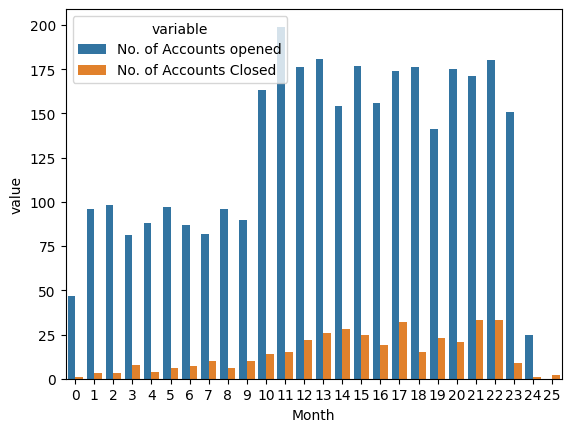

In [90]:
sns.barplot(data=accounts_opening_and_closing_by_month.melt(id_vars= 'Month'),x = 'Month', y = 'value', hue='variable') # need long format for hue parameter